# Put the R in RAG

In [80]:
# Debug pinecone installation
!pip show pinecone

Name: pinecone
Version: 6.0.2
Summary: Pinecone client and SDK
Home-page: https://www.pinecone.io
Author: Pinecone Systems, Inc.
Author-email: support@pinecone.io
License: Apache-2.0
Location: c:\Users\kadda\github_repos\rag-gen-ai\.venv\Lib\site-packages
Requires: certifi, pinecone-plugin-interface, python-dateutil, typing-extensions, urllib3
Required-by: 


In [81]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from bs4 import BeautifulSoup

import hashlib
import os
from dotenv import load_dotenv

from datetime import datetime

from tqdm import tqdm

In [82]:
load_dotenv()
# Retrieve the Pinecone API key from user data
pinecone_api_key = os.environ.get("PINECONE_API_KEY")

print(f"API key loaded: {pinecone_api_key[:3]}..." if pinecone_api_key else "No API key found")

# Initialize the OpenAI client
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# Define constants [vector size, embedding engine] small: 1536 medium: 4096 large: 12288
ENGINE = 'text-embedding-3-small'

# Initialize Pinecone client
pc = Pinecone(
    pinecone_api_key=pinecone_api_key
)

API key loaded: pcs...


In [83]:
INDEX_NAME = 'semantic-search-rag-index' # name of the collection of documents
NAMESPACE = 'default' # split the documents into namespaces. default is 'default'

def get_embeddings(text, engine=ENGINE):
    """
    Get the embeddings for a given text using OpenAI's API.
    """
    response = openai_client.embeddings.create(
            input=text,
            model=engine
        )
    return [data.embedding for data in list(response.data)]

def get_embedding(text, engine=ENGINE):
    """
    Get the embedding for a given text using OpenAI's API.
    Use the get_embeddings function to get the embedding for a single text
    """
    return get_embeddings(text, engine)[0]

len(get_embedding("Hello world!")), len(get_embeddings(["Hello world!", "Servus Welt"]))


(1536, 2)

In [84]:
if INDEX_NAME not in pc.list_indexes().names():
    # Create the index if it doesn't exist
    pc.create_index(
        name=INDEX_NAME, # name of the index
        dimension=1536, # dimension of the embedding for OpenAI's text-embedding-3-small
        metric='cosine', # metric for similarity search
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1',
        )
    )

# Store the index as variable
index = pc.Index(INDEX_NAME)
index

In [85]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [86]:
# # delete all documents in the index
# index.delete(delete_all=True, namespace=NAMESPACE)
# # check if the index is empty
# index.describe_index_stats()

In [87]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    # depending the vectorDB, We need to know how to upload the data to Pinecone and read
    # Compressed version of the text
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [88]:
def prepare_data_for_pinecone(texts, engine=ENGINE, urls=None):
    """
    Prepare the data for Pinecone by creating a list of tuples with the ID, embedding, and metadata.
    """

    now = datetime.now()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() 
    # function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now.isoformat())  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]

    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses
    

In [89]:
texts = ['hi']

In [90]:
_id, embedding, metadata = prepare_data_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-21T12:42:48.422869'}


In [91]:
urls = ['fake.url']
_id, embedding, metadata = prepare_data_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-21T12:42:48.880960', 'url': 'fake.url'}


In [92]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_data_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_data_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_data_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [93]:
# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [94]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [95]:
query_from_pinecone('An welchen Tagen im Mai 2025 kann man die Ausstellung besuchen?')


[]

In [96]:
def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)

{}

In [97]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [98]:
# specific of the website strucutre munchen.de
# https://www.muenchen.de/en/events/
base_url = 'https://www.muenchen.de'
event_url = f'{base_url}/en/events/'
print(base_url)
print(event_url)

https://www.muenchen.de
https://www.muenchen.de/en/events/


In [99]:
import requests
import re

def find_links_with_pattern(url, pattern):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [link.get('href') for link in links]

# Example usage
pattern = r'^/en/node/'

matching_links = find_links_with_pattern(event_url, pattern)
len(matching_links)

19

In [100]:
urls = []

In [101]:
for link in matching_links:
    urls.append(f'{base_url}{link}')
    print(f'{base_url}{link}')


https://www.muenchen.de/en/node/96219
https://www.muenchen.de/en/node/100789
https://www.muenchen.de/en/node/67524
https://www.muenchen.de/en/node/93314
https://www.muenchen.de/en/node/100464
https://www.muenchen.de/en/node/97367
https://www.muenchen.de/en/node/93196
https://www.muenchen.de/en/node/94241
https://www.muenchen.de/en/node/100046
https://www.muenchen.de/en/node/96560
https://www.muenchen.de/en/node/98241
https://www.muenchen.de/en/node/79526
https://www.muenchen.de/en/node/91505
https://www.muenchen.de/en/node/91753
https://www.muenchen.de/en/node/99414
https://www.muenchen.de/en/node/99903
https://www.muenchen.de/en/node/101130
https://www.muenchen.de/en/node/89285
https://www.muenchen.de/en/node/95674


In [102]:
from bs4 import BeautifulSoup
import requests

for matching_link in tqdm(matching_links):
    full_link = base_url + matching_link
    r = requests.get(full_link)
    soup = BeautifulSoup(r.content, 'html.parser')
    for link in soup.find_all('a'):
        if 'href' in link.attrs:
            if link['href'].startswith('/') and 'sehenswuerdigkeiten' in link['href']:
                urls.append(base_url + link['href'])
    
urls = list(set([u.lower().strip() for u in urls]))
len(urls)

100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


36

In [103]:
for url in urls:
    print(url)

https://www.muenchen.de/en/node/99903
https://www.muenchen.de/en/node/97367
https://www.muenchen.de/en/node/95674
https://www.muenchen.de/en/node/99414
https://www.muenchen.de/en/node/94241
https://www.muenchen.de/en/node/91753
https://www.muenchen.de/sehenswuerdigkeiten/museen/infopoint-museen-schloesser-bayern
https://www.muenchen.de/sehenswuerdigkeiten/museen/muenchner-stadtmuseum
https://www.muenchen.de/en/node/101130
https://www.muenchen.de/en/node/96560
https://www.muenchen.de/sehenswuerdigkeiten/webcam-live-aus-muenchen-marienplatz-olympiapark-und-mehr
https://www.muenchen.de/sehenswuerdigkeiten/museen/zentralinstitut-fuer-kunstgeschichte
https://www.muenchen.de/sehenswuerdigkeiten/museen/ns-dokumentationszentrum-muenchen
https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-urban-and-contemporary-art-muca
https://www.muenchen.de/sehenswuerdigkeiten/museen/bayerische-staatsbibliothek
https://www.muenchen.de/sehenswuerdigkeiten/museen/amuseum-of-contemporary-art
https://www.m

In [104]:
import re

def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        "Skip to content", "Skip to main content", "Menu", "Sign in", "Print", "Views:", "Comments",
        "Footer menu", "Give us Feedback.", "Did this answer your question?", "No Yes No", "Thanks for your feedback.", "Events", "Culture, Leisure", "Restaurants", "Shopping", "Sights", "Tourism", 
        "Hotels", "Business", "Living", "Transportation", "Citizen service", "English", "Branchenbuch", 
        "Anzeige", "Search", "muenchen.de", "Das offizielle Stadtportal", "Home"
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()
    print(text)
    return text

In [105]:
import requests

event_docs = []
for url in tqdm(urls):
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    # Find the main content container
    main_content = soup.find('main', id='content')

    if main_content:
        # Extract text from the main content area
        body_text = main_content.get_text(separator=' ', strip=True)
        # Clean the extracted text
        cleaned_text = clean_string(body_text)
        event_docs.append(dict(text=cleaned_text, url=url))
    else:
         print("No content found for URL:", url)

  3%|▎         | 1/36 [00:00<00:04,  8.38it/s]

https://www.muenchen.de/en/node/99903
Ad Videoinstallation im NSDokuzentrum overexposedunderexposed Mit der Videoinstallation overexposedunderexposed untersuchen Mila Zhluktenko und Daniel Asadi Faezi acht Orte in München, die eine Geschichte terroristischer Gewalt in sich tragen. Vom 8. Mai bis zum 19. Oktober 2025 ist die Installation im NSDokuzentrum in München zu sehen. Datum und Veranstaltungsort 21.05.2025 1000 until 1900 h NSDokumentationszentrum München nsdoku More actions Share on Facebook Share via WhatsApp Copy link Über die Installation Orte des Terrors in München An den über das Stadtgebiet verstreut liegenden Orten wurden Menschen aus rechtsextremen, rassistischen und antisemitischen Motiven getötet, verletzt und traumatisiert. Manche der Taten sind weit über die Grenzen der Stadt hinaus bekannt, andere sind bis heute nicht im kollektiven Gedächtnis verankert. Um Aufklärung dieser Verbrechen und um Erinnerung an die Opfer wird zum Teil noch gerungen. Jeder Terrorakt hat s

  6%|▌         | 2/36 [00:00<00:03,  8.98it/s]

Ad Ausstellung im Museum Brandhorst Fünf Freunde. John Cage, Merce Cunningham, Jasper Johns, Robert Rauschenberg, Cy Twombly Unter dem Titel Fünf Freunde nimmt das Museum Brandhorst vom 10. April bis 17. August 2025 einen Künstlerkreis in den Fokus, der die Kunst der Nachkriegszeit in Musik, Tanz, Malerei, Skulptur und Zeichnung entscheidend geprägt hat. Datum und Veranstaltungsort 21.05.2025 1000 until 1800 h Museum Brandhorst Design Parat.cc More actions Share on Facebook Share via WhatsApp Copy link Darum geht es in der Ausstellung John Cage , Merce Cunningham , Jasper Johns , Robert Rauschenberg und Cy Twombly schufen durch ihren intimen Austausch eine besondere Verbindung zwischen den künstlerischen Gattungen und Medien. Mit über hundertfünfzig Kunstwerken, Partituren, Bühnenrequisiten, Kostümen, Fotografien und Archivalien ermöglicht die Schau einen Einblick in das Zusammenspiel der fünf Künstlerfreunde. Das Museum Brandhorst rückt damit auch Cy Twomblys Schaffen, das einen zentr

 17%|█▋        | 6/36 [00:00<00:03,  9.53it/s]

Ad Ausstellung im Jüdischen Museum München bis 1. März 2026 Die Dritte Generation. Der Holocaust im familiären Gedächtnis 80 Jahre nach dem Holocaust beleuchtet die Die Dritte Generation. Der Holocaust im familiären Gedächtnis transgenerationale Traumata und das emotionale Erbe der Überlebenden. Die Ausstellung im Jüdischen Museum München läuft bis zum 1. März 2026. Datum und Veranstaltungsort 21.05.2025 1000 until 1800 h Jüdisches Museum München Eva Jünger Jüdisches Museum München More actions Share on Facebook Share via WhatsApp Copy link Generationenübergreifende Geschichten und Traumata im Blickpunkt Wie Erinnern, wenn kaum noch Zeitzeuginnen befragt werden können, die den Holocaust unmittelbar erlebt haben? An diese Frage knüpft die Ausstellung Die Dritte Generation. Der Holocaust im familiären Gedächtnis an. Überlebende des Holocaust haben ihre Geschichten, aber auch ihre Traumata an ihre Kinder und Enkelkinder weitergegeben. Während die Zweite Generation mit den psychischen und 

 19%|█▉        | 7/36 [00:01<00:08,  3.62it/s]

Information und Ideen für eure Museumsbesuche in München und Bayern Infopoint Museen Schlösser in Bayern Aktuelle AusstellungsTipps und Beratung Im Infopoint Museen Schlösser in Bayern erhalten Touristinnen und Einheimische aktuelle und umfassende Informationen über rund 1.300 Museen und Schlösser in Bayern. Adresse und Öffnungszeiten Alter Hof 1 , 80331 München Öffnungszeiten Mi geöffnet 1000 1800 Mo 1000 1800 Di 1000 1800 Mi 1000 1800 Do 1000 1800 Fr 1000 1800 Sa 1000 1800 So geschlossen Hinweis Sonn und Feiertags geschlossen Anfahrt Bayerisches Landesamt für DenkmalpflegeForstner Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch des Infopoints im Alten Hof? Museen in Bayern Ob Touristinnen oder Einheimische die Mitarbeiterinnen geben euch persönlich vor Ort, aber auch telefonisch und per EMail, Auskunft über alles, was zur Planung eines Ausflugs nützlich ist Was ist geboten? Informationen zu Öffnungszeiten, Adressen, Sonderausstellungen, F

 25%|██▌       | 9/36 [00:02<00:07,  3.45it/s]

Sanierungsarbeiten über viele Jahre dennoch bleibt das Museum aktiv! Münchner Stadtmuseum Geschlossen wegen Sanierung Das Münchner Stadtmuseum ist für die Generalsanierung voraussichtlich bis 2031 geschlossen. Ab 15. Mai 2025 bis 2027 wird im historischen Zeughaus die Interimsausstellung What the City. Perspektiven unserer Stadt gezeigt. Das Filmmuseum bleibt bis Juni 2027 in Betrieb. Adresse und Öffnungszeiten St.JakobsPlatz 1 , 80331 München Anfahrt Münchner Stadtmuseum Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Generalsanierung des Stadtmuseums seit 2024 Auer Weber Visualisierung Jonas Bloch Der Entwurf von Auer Weber für den neuen Museumsbau Seit Januar 2024 ist das Münchner Stadtmuseum voraussichtlich bis Mitte 2031 geschlossen und macht sich fit für die Zukunft Der Gebäudekomplex wird umfassend saniert unter anderem entstehen ein neuer Haupteingang am Rindermarkt und ein überdachtes Atrium im Innenhof mit einem Kubus als neuem Museumsmittelpunkt. Zudem wird

 28%|██▊       | 10/36 [00:02<00:06,  4.15it/s]

Ad Ausstellung im MUCA über den portugiesischen UrbanArtKünstler Vhils Strata Das Museum of Urban and Contemporary Art präsentiert mit Strata die erste Einzelausstellung des portugiesischen UrbanArtKünstlers Vhils in Deutschland. Vom 12. März bis 30. November 2025 erleben Besucherinnen seine künstlerische Entwicklung von 2005 bis 2025 anhand vielfältiger Materialien und Techniken eine Reise durch zwei Jahrzehnte innovativer urbaner Kunst. Datum und Veranstaltungsort 21.05.2025 1000 until 1800 h Museum of Urban and Contemporary Art Jose Pando Lucas More actions Share on Facebook Share via WhatsApp Copy link Was erwartet euch in der Ausstellung? Der portugiesische Künstler Vhils ist international bekannt für seine unkonventionelle urbane Kunst, in der er Oberflächen gezielt zerstört, um verborgene Geschichten ans Licht zu bringen. Die Ausstellung bietet ein immersives Erlebnis und präsentiert eindrucksvolle Werke aus Beton, Holz, Metall und Papier sowie Videos darunter filigrane Wandschn

 33%|███▎      | 12/36 [00:03<00:08,  2.95it/s]

ZI Kunsthistorisches Forschungsinstitut und wissenschaftlicher Austausch Zentralinstitut für Kunstgeschichte München Infos zu Bibliothek und Photothek Das Zentralinstitut für Kunstgeschichte ist das einzige außeruniversitäre kunsthistorische Forschungsinstitut in Deutschland. Es beschäftigt sich mit der Geschichte der Kunst im globalen Kontext. Adresse und Öffnungszeiten KatharinavonBoraStr. 10 , 80333 München Öffnungszeiten Mi geöffnet 0900 2000 Mo 0900 2000 Di 0900 2000 Mi 0900 2000 Do 0900 2000 Fr 0900 2000 Sa geschlossen So geschlossen Hinweis Angegeben sind die Öffnungszeiten der Bibliothek Anfahrt Helena Heilig Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Zentralinstitut für Kunstgeschichte App MunichArtToGo Geht mit der neuen App des ZI auf eine interaktive Entdeckungsreise durch die Kunststadt München von 1800 bis heute. Mehr Infos zur App Warum lohnt sich ein Besuch im ZI in München? Gunnar Menzel Das Zentralinstitut für Kunstgeschichte hat seinen Sitz im 

 36%|███▌      | 13/36 [00:04<00:11,  1.95it/s]

Lern und Erinnerungsort zur Geschichte des Nationalsozialismus NSDokumentationszentrum München Das NSDokumentationszentrum München ist der zentrale Ort zur Auseinandersetzung mit der nationalsozialistischen Vergangenheit der Stadt. Adresse und Öffnungszeiten MaxMannheimerPlatz 1 , 80333 München Öffnungszeiten Mi geöffnet 1000 1900 Mo geschlossen Di 1000 1900 Mi 1000 1900 Do 1000 1900 Fr 1000 1900 Sa 1000 1900 So 1000 1900 Hinweis An Feiertagen, die auf einen Montag fallen, hat das NSDokumentationszentrum geöffnet. Gesonderte Öffnungszeiten an Feiertagen. Anfahrt nsdoku Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im NSDokumentationszentrum München? Connolly Weber Die Dokumentation ist in inhaltliche Themenschwerpunkte gegliedert, die durch die Ausstellung leiten Das NSDokumentationszentrum München erinnert am historischen Ort an die Verbrechen der NSDiktatur und vermittelt die Geschichte des Nationalsozialismus mit Blick auf die Gegenwar

 39%|███▉      | 14/36 [00:05<00:13,  1.58it/s]

Museum of Urban and Contemporary Art Entdeckt StreetArt im MUCA Museum of Urban and Contemporary Art Infos zu Ausstellungen und mehr Das Museum of Urban and Contemporary Art zeigt auf drei Etagen und in einem angrenzenden Bunker die Werke internationaler Künstlerinnen der Urban Art Szene. Im MUCA läuft derzeit die Ausstellung Strata mit Werken des portugiesischen Künstlers Vhils. Adresse und Öffnungszeiten Hotterstraße 12 , 80331 München Anfahrt MUCA Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Jose Pando Lucas Schaut euch Strata an Vom 12. März bis 30. November 2025 könnt ihr den portugiesischen Künstler Vhils und seine Werke aus Beton, Holz, Metall und Papier erleben. Erfahrt hier mehr Warum lohnt sich ein Besuch im MUCA? Alexander Silva Vhils Cityscape Munich Das MUCA ist Deutschlands erstes Museum für Urban Art. Es möchte einen Beitrag dazu leisten, die Urban Street Art Szene kunsthistorisch einzuordnen und sie als eigene Kunstrichtung anzuerkennen. Was ist geb

 42%|████▏     | 15/36 [00:06<00:15,  1.35it/s]

Stabi München Universalbibliothek mit kultureller Bedeutung Bayerische Staatsbibliothek Infos, Ausstellungen und Tipps Die Bayerische Staatsbibliothek ist die größte wissenschaftliche Universalbibliothek Deutschlands und das in historischem Ambiente. Adresse und Öffnungszeiten Ludwigstr. 16 , 80539 München Öffnungszeiten Mi geöffnet 0800 00 Mo 0800 00 Di 0800 00 Mi 0800 00 Do 0800 00 Fr 0800 00 Sa 0800 00 So 0800 00 Hinweis 2025 ist die Bibliothek an folgenden Tagen geschlossen 1. Januar 6. Januar 4. März 18. 21. April 1. Mai 29. Mai 8.9. Juni 19. Juni 15. August 3. Oktober 1. November 24. 26. Dezember 31. Dezember Anfahrt Bayerische Staatsbibliothek Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren In Kooperation mit dem Kulturreferat und den Museen Dieser Beitrag über die Münchner Museen wird vom Kulturreferat der Landeshauptstadt München gefördert und ist in Kooperation mit der Landesstelle für die nichtstaatlichen Museen in Bayern konzipiert worden. Die Inhalte wurd

 47%|████▋     | 17/36 [00:07<00:11,  1.71it/s]

Street ArtMuseum in München AMUSEUM of Contemporary Art Infos zu Ausstellungen und mehr Seit seiner Eröffnung im Jahr 2022 hat sich das AMUSEUM als Ausstellungsraum der internationalen Street ArtBewegung etabliert. Im Rahmen wechselnder Ausstellungen zeigen renommierte Künstlerinnen und Künstler der zeitgenössischen Kunst ihre Werke im Herzen des Univiertels, in unmittelbarer Nachbarschaft zum Münchner Museumsareal. Adresse und Öffnungszeiten Schellingstraße 3 , 80799 München Öffnungszeiten Mi geöffnet 1200 1900 Mo geschlossen Di geschlossen Mi 1200 1900 Do 1200 1900 Fr 1200 1900 Sa 1200 1900 So 1200 1900 Hinweis Anfahrt AMUSEUM Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren AMUSEUM Aktuelle Ausstellung NoNÅME Sell la Vie Bis zum 20. Juli 2025 zeigt das AMUSEUM rund 90 bisher unveröffentlichte OriginalWerke des anonymen Street ArtKünstlers. Hier erfahrt ihr mehr Warum lohnt sich ein Besuch im AMUSEUM? Sie gelten als öffentlichkeitsscheu, verraten mitunter bloß ihren 

 50%|█████     | 18/36 [00:07<00:08,  2.20it/s]

Ad Tickets für die Schau in der Kleinen Olympiahalle Körperwelten in München Am Puls der Zeit Einblicke, die unter die Haut gehen Vom 11. April bis zum 14. September 2025 ist die Ausstellung Körperwelten in der Kleinen Olympiahalle zu sehen. Unter dem Titel Am Puls der Zeit ermöglicht die Plastinatschau einen neuen Blick auf die Herausforderungen des Menschen im 21. Jahrhundert. Datum und Veranstaltungsort 21.05.2025 1000 until 1800 h Kleine Olympiahalle Tickets Holger BergKörperwelten More actions Share on Facebook Share via WhatsApp Copy link Gunther von Hagens Plastinate in einer neuen Ausstellung Zum dritten Mal schauen die Körperwelten in München vorbei diesmal mit einem hochaktuellen Thema Wie verletzlich ist der Mensch und welche Potenziale hat er? Plastinator Dr. Gunther von Hagens und Kuratorin Dr. Angelina Whalley regen die Besucherinnen dazu an, ihre Gesundheit bewusster wahrzunehmen und die Auswirkungen des modernen Lebensstils zu hinterfragen. Neben Aspekten wie Ernährung,

 53%|█████▎    | 19/36 [00:07<00:08,  2.03it/s]

Taucht ein in die Welt der Fundstücke und Ausgrabungen Archäologische Staatssammlung München Infos und Tipps zum Museum Eine Reise zurück in die Vergangenheit der menschlichen Existenz Nach etwa acht Jahren Bauzeit erstrahlt das Museum seit 2024 in neuem Glanz und präsentiert euch seine Exponate zu 120.000 Jahren bayerischer Siedlungsgeschichte. Adresse und Öffnungszeiten Lerchenfeldstr. 2 , 80538 München Öffnungszeiten Mi geöffnet 1000 1700 Mo geschlossen Di 1000 1700 Mi 1000 1700 Do 1000 1900 Fr 1000 1700 Sa 1000 1700 So 1000 1900 Hinweis Anfahrt ASM, Stefanie Friedrich Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Landesmuseum Württemberg, Hendrik Zwietasch Schaut euch die Sonderausstellung an Unter dem Titel Urformen Eiszeitkunst begreifen könnt ihr bis 21. April Repliken urzeitlicher Kunstwerke bewundern. Erfahrt mehr Warum lohnt sich ein Besuch in der Archäologischen Staatssammlung? Was ist geboten? Die Archäologische Staatssammlung ist in fünf Abteilungen unt

 58%|█████▊    | 21/36 [00:09<00:07,  1.99it/s]

Kunsthalle München Ein vielfältiges Kunstprogramm im Herzen der Stadt Kunsthalle München Ausstellungen aus Malerei, Fotografie und Design Drei bis vier Ausstellungen zeigt die international renommierte Kunsthalle in den Münchner Fünf Höfen jedes Jahr. Dabei werden alle Facetten der Kunst beleuchtet. Adresse und Öffnungszeiten Theatinerstr. 8 , 80333 München Öffnungszeiten Mi geöffnet 1000 2000 Mo 1000 2000 Di 1000 2000 Mi 1000 2000 Do 1000 2000 Fr 1000 2000 Sa 1000 2000 So 1000 2000 Hinweis An jedem dritten Mittwoch des Monats ist die Ausstellung zur Afterwork bis 22 Uhr geöffnet. Sonderöffnung für Schulklassen jeden Mittwoch von 910 Uhr Anfahrt Kunsthalle München Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Jeffrey Milstein Schaut euch Civilization an Von 11.04.24.8.25 folgt die Kunsthalle München den Spuren der Menschheit rund um den Globus aus dem Blickwinkel von über 100 international renommierten Fotografinnen. Erfahrt mehr Wissenswertes über einen Besuch in d

 67%|██████▋   | 24/36 [00:10<00:05,  2.37it/s]

Museum Brandhorst Zeitgenössische Kunst in Münchens Zentrum Museum Brandhorst im Kunstareal Infos zu Ausstellung, Führung und Café In einem bunten Kunstbau mitten im Münchner Kunstareal präsentiert das Museum Brandhorst Werke zeitgenössischer Künstlerinnen, unter anderem von Andy Warhol und Cy Twombly. Adresse und Öffnungszeiten Theresienstr. 35a , 80333 München Öffnungszeiten Mi geöffnet 1000 1800 Mo geschlossen Di 1000 1800 Mi 1000 1800 Do 1000 2000 Fr 1000 1800 Sa 1000 1800 So 1000 1800 Hinweis An folgenden Feiertagen geschlossen Faschingsdienstag, Tag der Arbeit, Heiligabend, Erster Weihnachtstag, Silvester Anfahrt Andreas Lechtape, Museum Brandhorst Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Museum Brandhorst? Museum Brandhorst Besucherinnen vor den Werken von Cy Twombly im Rosensaal des Museums Brandhorst Die spektakuläre MuseumsFassade aus 36.000 Keramikstäben kennt in München jeder doch was verbirgt sich dahinter? Was ist ge

 69%|██████▉   | 25/36 [00:10<00:03,  2.89it/s]

Ad Sonderausstellung in der Archäologischen Staatssammlung Planet Africa Eine archäologische Zeitreise Von 16. Mai bis 28. September 2025 gastiert die Ausstellung Planet Africa Eine archäologische Zeitreise an der Archäologischen Staatssammlung. Dieses innovative, kontinentübergreifende Ausstellungsprojekt der Staatlichen Museen zu Berlin und des Deutschen Archäologischen Instituts hat die afrikanische Archäologie zum Fokus. Zur Ausstellung gibt es ein umfangreiches Begleitprogramm. Datum und Veranstaltungsort 21.05.2025 1000 until 1700 h Archäologische Staatssammlung Doris Fleischer More actions Share on Facebook Share via WhatsApp Copy link Darum geht es in der Ausstellung Afrika ist der Kontinent mit der längsten Anwesenheit des Menschen. Hier lagen unsere Ursprünge und die unserer evolutionären Vorfahren, die sich fortwährenden Veränderungen der Lebensräume anpassten und dafür neue Überlebensstrategien entwickelten. Von Afrika aus wurden über die Jahrtausende hinweg neue Kulturtech

 78%|███████▊  | 28/36 [00:11<00:03,  2.66it/s]

Lenbachhaus Entdeckt die berühmte Sammlung des Blauen Reiter Lenbachhaus München Infos zur städtischen Galerie, Ausstellungen und Kunstbau Das Lenbachhaus ist berühmt für die weltweit größte Sammlung der Gruppe des Blauen Reiter um Franz Marc. Es gibt aber noch viele weitere Gemälde zu entdecken. Adresse und Öffnungszeiten Luisenstr. 33 , 80333 München Öffnungszeiten Mi geöffnet 1000 1800 Mo geschlossen Di 1000 1800 Mi 1000 1800 Do 1000 2000 Fr 1000 1800 Sa 1000 1800 So 1000 1800 Hinweis Jeden 1. Donnerstag im Monat ist der Eintritt von 18 bis 22 Uhr frei. Anfahrt Städtische Galerie im Lenbachhaus und Kunstbau Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Lenbachhaus? F. Holzherr, Städt. Galerie im Lenbachhaus Kunstbau Schon von Außen ist das Lenbachhaus ein Blickfang Eine historische Künstlervilla mit modernem Anbau Die weltweite größte Sammlung des Blauen Reiter ist ein Muss für Touristen und Einheimische! Was ist geboten? Das Lenbac

 81%|████████  | 29/36 [00:13<00:03,  1.79it/s]

Zeitgenössische Kunst am Englischen Garten Das Haus der Kunst Haus der Kunst in München Aktuelle Ausstellungen, Tipps und Infos Es gehört zu den großen internationalen Kunstmuseen Das Haus der Kunst zeigt jährlich wechselnde Ausstellungen der Gegenwartskunst auf Weltniveau. Adresse und Öffnungszeiten Prinzregentenstr. 1 , 80538 München Öffnungszeiten Mi geöffnet 1000 2000 Mo 1000 2000 Di geschlossen Mi 1000 2000 Do 1000 2200 Fr 1000 2000 Sa 1000 2000 So 1000 2000 Hinweis Geschlossen 24. und 31. Dezember Anfahrt Haus der Kunst München, 2023, Foto Maximilian Geuter Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Haus der Kunst? Haus der Kunst München, 2023, Foto Maximilian Geuter Das Haus der Kunst besitzt keine eigene Sammlung, es ist ein reines Ausstellungshaus. Und das ist seine große Stärke So hat es die Möglichkeit, den wechselnden Programmen viel Raum zu geben. Was ist geboten? Mit seinen Ausstellungen, Performances und Musikveransta

 89%|████████▉ | 32/36 [00:13<00:01,  2.80it/s]

Museum Mineralogia Die Welt der Edelsteine und Kristalle Museum Mineralogia München Alle Infos zu den Ausstellungen Sie glitzern, funkeln und manche sind heiß begehrt Im Museum Mineralogia entdeckt ihr die faszinierende Welt der Kristalle, Edelsteine, Edelmetalle und Meteoriten. Adresse und Öffnungszeiten Theresienstr. 41 , 80333 München Öffnungszeiten Mi geöffnet 1200 1600 Mo geschlossen Di 1200 1600 Mi 1200 1600 Do 1200 1600 Fr 1200 1600 Sa 1300 1700 So 1300 1700 Hinweis Feiertagsöffnungszeiten an allen Feiertagen von 1317 Uhr geöffnet, außer diese fallen auf einen Montag. Geschlossen Heiligabend, 1. Weihnachtsfeiertag, Silvester, Neujahr und am Faschingsdienstag Anfahrt München.de Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren In Kooperation mit dem Kulturreferat und den Museen Dieser Beitrag über die Münchner Museen wird vom Kulturreferat der Landeshauptstadt München gefördert und ist in Kooperation mit der Landesstelle für die nichtstaatlichen Museen in Bayern k

 94%|█████████▍| 34/36 [00:14<00:00,  3.55it/s]

us KulturHighlights Perlen der Münchner Kultur Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte in allen Preislagen buchen Hier im Überblick Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks So schön ist München München mal anders Eure Stadtführung durch München mit oder ohne Guide LGBTIQ in München Tipps und Informationen für die queere Community Sehenswerte UBahnStationen Kunstwerke im Untergrund Sehenswerte UBahnhöfe Immer einen Besuch wert Museen in München Die wichtigsten Museen und Galerien Münchens Olympiapark Erholen, Staunen, Erleben im weitläufigen Park Besucherservice Tierpark Hellabrunn Infos zu Öffnungszeiten, Eintrittspreisen und Anfahrt ServiceTipps für den MünchenBesuch MVG Infos zu UBahn, Bus und Tram Tickets, Fahrpläne, LiveAuskunft, Mieträder Die Infos Touristeninformation Die wichtigsten InfoPoints Hier gibts Hinweise für Touristen Stadtrundfahrten in München. Eine Übersicht der Anbieter Stadtführungen Bei diesen Anbietern wird die Städtetour zum Erlebni

 97%|█████████▋| 35/36 [00:15<00:00,  2.36it/s]

Vielfalt jüdischer Kultur erleben Jüdisches Museum München Ausstellungen, Rundgänge, Programm Das Jüdische Museum München vermittelt ein Bild der Vielfalt jüdischer Geschichte, Kunst und Kultur von der Vergangenheit bis heute. Das Museum ist ein lebendiger Ort zum Austausch und zur offenen Diskussion. Adresse und Öffnungszeiten St.JakobsPlatz 16 , 80331 München Öffnungszeiten Mi geöffnet 1000 1800 Mo geschlossen Di 1000 1800 Mi 1000 1800 Do 1000 1800 Fr 1000 1800 Sa 1000 1800 So 1000 1800 Hinweis Anfahrt Daniel Schvarcz Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Jüdischen Museum München? Roland Halbe Das kubische Gebäude des Jüdischen Museums München ist schon von Außen absolut sehenswert Im Jüdischen Museum München wird die Vielfalt jüdischer Zugänge in der Geschichte, Kultur und Kunst erfahrbar mit dem Ziel eine plurale und diskriminierungsfreie Gesellschaft zu ermöglichen. Was ist geboten? Das Museum vermittelt Einblicke in die j

100%|██████████| 36/36 [00:15<00:00,  2.28it/s]

Galerie in der Prinzregentenstraße mit zeitgenössischer Kunst Galerie Bezirk Oberbayern Ausstellungen und Führungen In der Galerie Bezirk Oberbayern stellen Künstlerinnen mit und ohne Behinderung ihre Werke gemeinsam aus und gestalten ihre Ausstellung so, dass sie für alle zugänglich wird. Adresse und Öffnungszeiten Prinzregentenstr. 14 , 80538 München Öffnungszeiten Mi geöffnet 1000 1900 Mo 1000 1900 Di 1000 1900 Mi 1000 1900 Do 1000 1900 Fr 1000 1900 Sa geschlossen So geschlossen Hinweis Nach 18 Uhr bitte am Eingang klingeln. Feiertags geschlossen. Anfahrt Benjamin Schmidt Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch in der Galerie Bezirk Oberbayern? Bezirk Oberbayern Kunst inklusive! Die Galerie Bezirk Oberbayern macht Kunst für alle barrierefrei erlebbar. Was ist geboten? Es erwartet euch keine Dauerausstellung, sondern immer wieder neue Formate. Gezeigt werden zwei bis drei Doppelausstellungen pro Jahr, die Künstlerinnen mit und ohn

In [106]:
event_docs[0]

{'text': 'Ad Videoinstallation im NSDokuzentrum overexposedunderexposed Mit der Videoinstallation overexposedunderexposed untersuchen Mila Zhluktenko und Daniel Asadi Faezi acht Orte in München, die eine Geschichte terroristischer Gewalt in sich tragen. Vom 8. Mai bis zum 19. Oktober 2025 ist die Installation im NSDokuzentrum in München zu sehen. Datum und Veranstaltungsort 21.05.2025 1000 until 1900 h NSDokumentationszentrum München nsdoku More actions Share on Facebook Share via WhatsApp Copy link Über die Installation Orte des Terrors in München An den über das Stadtgebiet verstreut liegenden Orten wurden Menschen aus rechtsextremen, rassistischen und antisemitischen Motiven getötet, verletzt und traumatisiert. Manche der Taten sind weit über die Grenzen der Stadt hinaus bekannt, andere sind bis heute nicht im kollektiven Gedächtnis verankert. Um Aufklärung dieser Verbrechen und um Erinnerung an die Opfer wird zum Teil noch gerungen. Jeder Terrorakt hat seine eigene komplizierte Ges

In [107]:
BATCH_SIZE = 16
upload_texts_to_pinecone(
    texts=[g['text'] for g in event_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in event_docs]
)

100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


36

In [108]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [109]:
query = 'Ich will Lenbachhaus München besuchen'

results = query_from_pinecone(query, top_k=10)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

## Using Open Source Embedders

In [111]:
from sentence_transformers import SentenceTransformer, util

open_source_embedder = SentenceTransformer('all-MiniLM-L6-v2')

open_source_embedder.encode(['hi', 'hello', 'sup']).shape

(3, 384)

In [112]:
open_source_embedder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Prune some duplicates

In [114]:
stats = index.describe_index_stats()
print(stats.get('total_vector_count'))

36


In [113]:
import pandas as pd

dimension = 1536  # Your embedding dimension for text-embedding-3-small
zero_vector = [0.0] * dimension
total_vector_count = stats.get('total_vector_count')
# Query with this vector and a high limit to fetch all
all_vectors = index.query(
    vector=zero_vector,
    top_k=total_vector_count,  # Set higher if you have more vectors
    include_metadata=True,
    namespace=NAMESPACE
)

# Convert to DataFrame
# scraped_df = pd.DataFrame(all_vectors['matches'])


# Option 2: If you know IDs, use list + fetch
# First get stats to know vector count
# stats = index.describe_index_stats()
# total_vectors = stats['namespaces'][NAMESPACE]['vector_count']

# First, check if there are any matches at all
print(f"Number of matches: {len(all_vectors['matches'])}")

# If there are matches, print the first one to see its structure
if all_vectors['matches']:
    print("First match structure:")
    print(all_vectors['matches'][0])

# scraped_df = pd.json_normalize(all_vectors['matches'])
# Method 1 (above not working) Extract data manually to create a structured DataFrame
data = []
for match in all_vectors['matches']:
    item = {
        'id': match['id'],
        'url': match['metadata'].get('url', ''),
        'date_uploaded': match['metadata'].get('date_uploaded', '')
    }
    data.append(item)

scraped_df = pd.DataFrame(data)

# Print all column names to verify the structure
print("DataFrame columns:", scraped_df.columns.tolist())

# Check if we have any data
print(f"DataFrame shape: {scraped_df.shape}")

# Find duplicates and remove them
duplicates = scraped_df[scraped_df.duplicated(subset=['url'], keep='first')]
duplicate_ids = duplicates['id'].tolist()

print(f"Found {len(duplicate_ids)} duplicate URLs")

# Delete duplicates from Pinecone
if duplicate_ids:
    print(f"Deleting {len(duplicate_ids)} duplicate vectors")
    index.delete(ids=duplicate_ids, namespace=NAMESPACE)

Number of matches: 36
First match structure:
{'id': '3777c4d7195425cd26b0beaec51a99fa',
 'metadata': {'date_uploaded': '2025-05-21T12:43:56.545019',
              'text': 'Ad Ausstellung im Lenbachhaus München Was zu '
                      'verschwinden droht, wird Bild. In der Ausstellung Was '
                      'zu verschwinden droht, wird Bild widmet sich das '
                      'Lenbachhaus seit 4. März 2025 dem Thema Vergänglichkeit '
                      'Gerade in Zeiten des Klimawandels eine äußerst '
                      'relevante und aktuelle Thematik. Datum und '
                      'Veranstaltungsort 21.05.2025 1000 until 1800 h '
                      'Lenbachhaus München Städtische Galerie im Lenbachhaus '
                      'und Kunstbau More actions Share on Facebook Share via '
                      'WhatsApp Copy link Mensch Natur Kunst Es ist ein '
                      'Gemeinplatz, erschreckend und faszinierend zugleich '
                      'All

### Synthetic test data generation

In [116]:
synthetic_data_prompt = '''I am designing a chatbot to use this document as information to our users.

Please write 10 questions that an average person not living in Munich interested in events, might ask that can definitely be answered using information using the provided document.

Try to ask in a way that's confusing to really test our system's knowledge but still fair.

I need 5 in german, 2 in english in that order.

Use this format to output:
Document: A given document to make questions from
JSON: ["german question 1", "german question 2", "german question 3", ...  "english question 1", "english question 2"]
###
Document: {document}
JSON:'''

response = openai_client.chat.completions.create(
    model='gpt-4o',
    messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_docs[1]['text'])}],
    temperature=1
)

In [117]:
languages = ['german']*5+['english']*2

In [118]:
import json

list(zip(
    languages,
    json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
))

[('german',
  "Was sind die Öffnungszeiten der Ausstellung 'Fünf Freunde' im Museum Brandhorst?"),
 ('german',
  "Wer sind die fünf Künstler, die in der 'Fünf Freunde' Ausstellung im Museum Brandhorst im Fokus stehen?"),
 ('german',
  'Welche historischen Ereignisse wurden in Twomblys Gemälden der 1960er Jahre aufgegriffen?'),
 ('german',
  "Worauf legt die Ausstellung 'Fünf Freunde' im Museum Brandhorst einen besonderen Fokus?"),
 ('german',
  'Welche Verbindung bestand zwischen Robert Rauschenberg und Cy Twombly?'),
 ('english',
  "When is the Festival Fünf Freunde featuring Merce Cunningham and John Cage's works?"),
 ('english',
  "What is the significance of the Black Mountain College in the context of the 'Fünf Freunde' exhibition?")]

In [119]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample 30% of the urls found
SAMPLE = .3
for i, event_doc in enumerate(tqdm(sample(event_docs, int(len(event_docs) * SAMPLE)))):
        
    response = openai_client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_doc['text'])}],
        temperature=1
    )
    try:
        questions = json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
        questions = [q.strip() for q in questions]
        assert len(questions) == len(languages)
        for language, question in zip(languages, questions):
            synthetic_questions.append(
            dict(
                language=language, 
                query=question, 
                expected_hash=my_hash(event_doc['text'])
            )
        )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


In [120]:
len(synthetic_questions)

70

In [121]:
for q in synthetic_questions[:10]:
    # print query, expected_hash, language
    print(f"[{q['expected_hash']}] [{q['language']}] {q['query']}")
    # print(f"[{q['language']}] {q['query']}")

[89afc26d87dfaf67f961dfe9f91793aa] [german] Ist die Ausstellung im Lenbachhaus eine Dauerveranstaltung oder endet sie irgendwann?
[89afc26d87dfaf67f961dfe9f91793aa] [german] Welche berühmten Künstler sind in der Ausstellung 'Eine neue Sprache' im Lenbachhaus vertreten?
[89afc26d87dfaf67f961dfe9f91793aa] [german] Wann genau wurde die Ausstellung 'Eine neue Sprache' eröffnet?
[89afc26d87dfaf67f961dfe9f91793aa] [german] Wo befindet sich das Lenbachhaus und welche wichtigen Werke werden dort ausgestellt?
[89afc26d87dfaf67f961dfe9f91793aa] [german] Sind die Ausstellungen im Lenbachhaus an allen Tagen der Woche geöffnet?
[89afc26d87dfaf67f961dfe9f91793aa] [english] What is the main focus of the exhibition 'Eine neue Sprache' at Lenbachhaus?
[89afc26d87dfaf67f961dfe9f91793aa] [english] How many works are being showcased in the 'Eine neue Sprache' exhibition at Lenbachhaus?
[226a805b93904d2fef51c268654777c5] [german] Wann ist das Museum Mineralogia an Feiertagen geöffnet?
[226a805b93904d2fef51

In [123]:
query_from_pinecone('Ist die Ausstellung im Lenbachhaus eine Dauerveranstaltung oder endet sie irgendwann?')


[{'id': '3777c4d7195425cd26b0beaec51a99fa',
  'metadata': {'date_uploaded': '2025-05-21T12:43:56.545019',
               'text': 'Ad Ausstellung im Lenbachhaus München Was zu '
                       'verschwinden droht, wird Bild. In der Ausstellung Was '
                       'zu verschwinden droht, wird Bild widmet sich das '
                       'Lenbachhaus seit 4. März 2025 dem Thema Vergänglichkeit '
                       'Gerade in Zeiten des Klimawandels eine äußerst '
                       'relevante und aktuelle Thematik. Datum und '
                       'Veranstaltungsort 21.05.2025 1000 until 1800 h '
                       'Lenbachhaus München Städtische Galerie im Lenbachhaus '
                       'und Kunstbau More actions Share on Facebook Share via '
                       'WhatsApp Copy link Mensch Natur Kunst Es ist ein '
                       'Gemeinplatz, erschreckend und faszinierend zugleich '
                       'Alles, was in Bildern festgehalten

In [124]:
def test_query(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash  # accuracy
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)  # Recall@top_k (10, etc)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [125]:
test_query(**synthetic_questions[2])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'german',
 'expected_hash': '89afc26d87dfaf67f961dfe9f91793aa',
 'top_hash': '89afc26d87dfaf67f961dfe9f91793aa'}

In [126]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|██████████| 70/70 [00:36<00:00,  1.89it/s]


result_in_pinecone_list    0.942857
top_result_correct         0.671429
dtype: float64


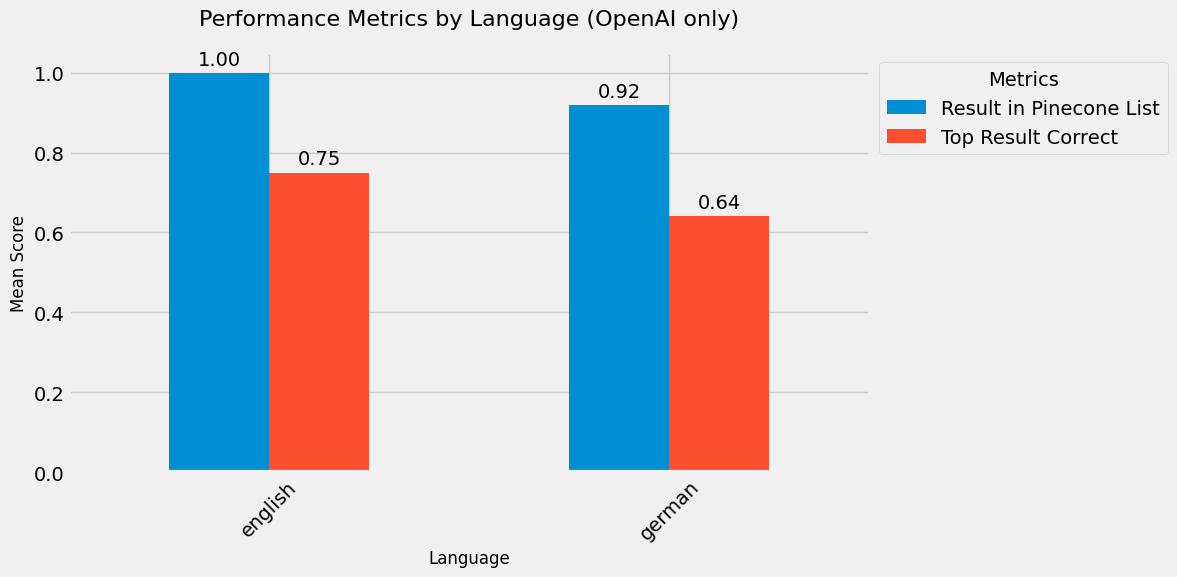

In [127]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Making Retrieval Better with Cohere's Re-Rank

In [ ]:
import cohere

load_dotenv()

co = cohere.Client(os.environ.get('COHERE_API_KEY'))